In [1]:
import tensorflow as tf
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError

class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self,
                 n_hidden_layers,
                 units,
                 initializer=tf.variance_scaling_initializer,
                 activation=tf.nn.elu,
                 optimizer_type=tf.train.AdadeltaOptimizer,
                 learning_rate=1e-2,
                 batch_size=128,
                 batch_norm_momentum=None,
                 dropout_rate=None):
        '''
        Initialize the DNNClassifier by strong all hyperparameters.
        '''
        self.n_hidden_layers = n_hidden_layers
        self.units = units
        self.initializer = initializer
        self.activation = activation
        self.optimizer_type = optimizer_type
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self._session = None
        
    def _dnn(self, inputs):
        '''
        Build the hidden layers, with support the BN(Batch Normalization) and dropout.
        '''
        with tf.name_scope('dnn'):
            for n in range(self.n_hidden_layers):
                if self.dropout_rate:
                    inputs = tf.layers.dropout(inputs=inputs,
                                               rate=self.dropout_rate,
                                               training=self._training)
                inputs = tf.layers.dense(inputs=inputs,
                                         units=self.units,
                                         kernel_initializer=self.initializer,
                                         activation=self.activation,
                                         name='hidden{}'.format(n))
                if self.batch_norm_momentum:
                    inputs = tf.layers.batch_normalization(inputs=inputs,
                                                           momentum=self.batch_norm_momentum,
                                                           training=self._training)
        return inputs
    
    def _build_graph(self, n_features, n_class):
        X = tf.placeholder(dtype=tf.float32, shape=(None, n_features), name='X')
        y = tf.placeholder(dtype=tf.int32, shape=(None), name='y')
        
        if self.batch_norm_momentum or self.dropout_rate:
            self._training = tf.placeholder_with_default(False, shape=(), name='training')
        else:
            self._training = None

        dnn_outputs = self._dnn(X)
        
        with tf.name_scope('classifier'):
            logits = tf.layers.dense(inputs=dnn_outputs,
                                     units=n_class,
                                     kernel_initializer=self.initializer,
                                     name='logits')
            y_prob = tf.nn.softmax(logits, name='y_prob')

        with tf.name_scope('loss'):
            xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
            loss = tf.reduce_mean(xentropy, name='loss')

        with tf.name_scope('train'):
            optimimzer = self.optimizer_type(learning_rate=self.learning_rate)
            training_op = optimimzer.minimize(loss)
        
        with tf.name_scope('metric'):
            correct = tf.nn.in_top_k(logits, y, 1)
            accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')
        
        init = tf.global_variables_initializer()
        saver = tf.train.Saver()
        
        self._X = X
        self._y = y
        self._y_prob = y_prob
        self._loss = loss
        self._training_op = training_op
        self._accuracy = accuracy
        self._init = init
        self._saver = saver
        
    def close_session(self):
        if self._session:
            self._session.close()
            
    def _get_model_params(self):
        with self._graph.as_default():
            gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in zip(gvars, self._session.run(gvars))}
    
    def _restore_model_params(self, model_params):
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name: self._graph.get_operation_by_name(gvar_name + '/Assign') for gvar_name in gvar_names}
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        self._session.run(assign_ops, feed_dict=feed_dict)
        
    def _random_shuffled_batch(self, X, y):
        n_samples, n_features = X.shape
        n_batches = int(np.ceil(n_samples // self.batch_size))
        random_idx = np.random.permutation(n_samples)
        for idx in np.array_split(random_idx, n_batches):
            X_batch, y_batch = X[idx], y[idx]
            yield X_batch, y_batch
    
    def fit(self, X, y, n_epochs, X_valid=None, y_valid=None):
        '''
        Fit the model to the given training set.
        If validation sets are provided, use early stopping.
        '''
        self.close_session()
        
        n_samples, n_features = X.shape
        self.labels_ = np.unique(y)  # Choose unique classes
        n_class = len(self.labels_)
        
        self.class_to_index_ = {label: idx for idx, label in enumerate(self.labels_)}
        self.index_to_class = {idx: label for idx, label in enumerate(self.labels_)}
        y = np.array([self.class_to_index_[label] for label in y], dtype=np.int32)
        
        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(n_features, n_class)
            # Extra operations are created if process batch normalization.
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        
        # Early stopping parameters
        max_chekcs_without_progress = 15
        checks_without_progress = 0
        best_loss = np.infty
        best_params = None
        
        # Logging metrics
        self.history = {'loss_val':[], 'acc_val':[]}
        
        self._session = tf.Session(graph=self._graph)
        with self._session.as_default() as sess:
            sess.run(self._init)
            for epoch in range(n_epochs):
                for X_batch, y_batch in self._random_shuffled_batch(X, y):
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    if self._training is not None:
                        feed_dict[self._training] = True
                    sess.run(self._training_op, feed_dict=feed_dict)
                    if extra_update_ops:
                        sess.run(extra_update_ops, feed_dict=feed_dict)
                if X_valid is not None and y_valid is not None:
                    loss_val, acc_val = sess.run([self._loss, self._accuracy],
                                                 feed_dict={self._X: X_valid, self._y: y_valid})
                    self.history['loss_val'].append(loss_val)
                    self.history['acc_val'].append(acc_val)
                    
                    if epoch % 10 == 0:
                        print('epoch={:5}\tacc_val={:3.6f}\tloss_val={:3.6f}\tbest_loss={:3.6f}'.format(
                            epoch, acc_val, loss_val, best_loss))
                    
                    if loss_val < best_loss:
                        best_params = self._get_model_params()
                        best_loss = loss_val
                        checks_without_progress = 0
                    else:
                        checks_without_progress += 1
            
                    if checks_without_progress >+ max_chekcs_without_progress:
                        print('Early stopping! Final metrics: epoch={:5}\tacc_val={:3.6f}\tloss_val={:3.6f}\tbest_loss={:3.6f}'.format(
                            epoch, acc_val, loss_val, best_loss))
                        break
            if best_params:
                self._restore_model_params(best_params)
        return self
    
    def predict_prob(self, X):
        if not self._session:
            raise NotFittedError('This estimator({}) is not fitted yet.'.format(self.__class__.__name__))
        with self._session.as_default() as sess:
            return self._y_prob.eval(feed_dict={self._X: X})
    
    def predict(self, X):
        y_preds = np.argmax(self.predict_prob(X), axis=1)
        return np.array([self.index_to_class[idx] for idx in y_preds], np.int32)
    
    def save(self, model_path):
        self._saver.save(self._session, model_path)

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def load_preprocessed_mnist(test_size=10000):
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    X = np.r_[X_train, X_test]
    y = np.r_[y_train, y_test]
    n_features = 28*28
    X = X.astype(np.float32).reshape(-1,n_features)
    y = y.astype(np.int32)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return train_test_split(X, y, test_size=test_size)

In [3]:
X_train, X_test, y_train, y_test = load_preprocessed_mnist()
X_valid, y_valid = X_test[:5000], y_test[:5000]
X_test, y_test = X_test[5000:], y_test[5000:]

In [4]:
from functools import partial

leaky_relu = partial(tf.nn.leaky_relu, alpha=0.1)

dnn_classifier = DNNClassifier(n_hidden_layers=5,
                               units=140,
                               batch_size=512,
                               activation=leaky_relu,
                               batch_norm_momentum=0.99)
dnn_classifier.fit(X_train, y_train, n_epochs=1000, X_valid=X_valid, y_valid=y_valid)

W0819 20:34:48.351625 139755099055936 deprecation.py:323] From <ipython-input-1-5e9fbb319e73>:45: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0819 20:34:48.646459 139755099055936 deprecation.py:323] From <ipython-input-1-5e9fbb319e73>:49: batch_normalization (from tensorflow.python.layers.normalization) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).


epoch=    0	acc_val=0.137400	loss_val=2.282107	best_loss=inf
epoch=   10	acc_val=0.745800	loss_val=0.967371	best_loss=1.036457
epoch=   20	acc_val=0.853400	loss_val=0.575870	best_loss=0.598453
epoch=   30	acc_val=0.890200	loss_val=0.429564	best_loss=0.439712
epoch=   40	acc_val=0.904000	loss_val=0.357192	best_loss=0.362792
epoch=   50	acc_val=0.916400	loss_val=0.314065	best_loss=0.317500
epoch=   60	acc_val=0.921800	loss_val=0.285140	best_loss=0.287428
epoch=   70	acc_val=0.927800	loss_val=0.264090	best_loss=0.265868
epoch=   80	acc_val=0.931800	loss_val=0.247593	best_loss=0.249046
epoch=   90	acc_val=0.934600	loss_val=0.234384	best_loss=0.235547
epoch=  100	acc_val=0.937600	loss_val=0.223482	best_loss=0.224513
epoch=  110	acc_val=0.939200	loss_val=0.214074	best_loss=0.214922
epoch=  120	acc_val=0.941200	loss_val=0.205820	best_loss=0.206551
epoch=  130	acc_val=0.943200	loss_val=0.198743	best_loss=0.199601
epoch=  140	acc_val=0.945000	loss_val=0.192656	best_loss=0.193094
epoch=  150	acc

DNNClassifier(activation=functools.partial(<function leaky_relu at 0x7f1ad4984840>, alpha=0.1),
              batch_norm_momentum=0.99, batch_size=512, dropout_rate=None,
              initializer=<class 'tensorflow.python.ops.init_ops.VarianceScaling'>,
              learning_rate=0.01, n_hidden_layers=5,
              optimizer_type=<class 'tensorflow.python.training.adadelta.AdadeltaOptimizer'>,
              units=140)

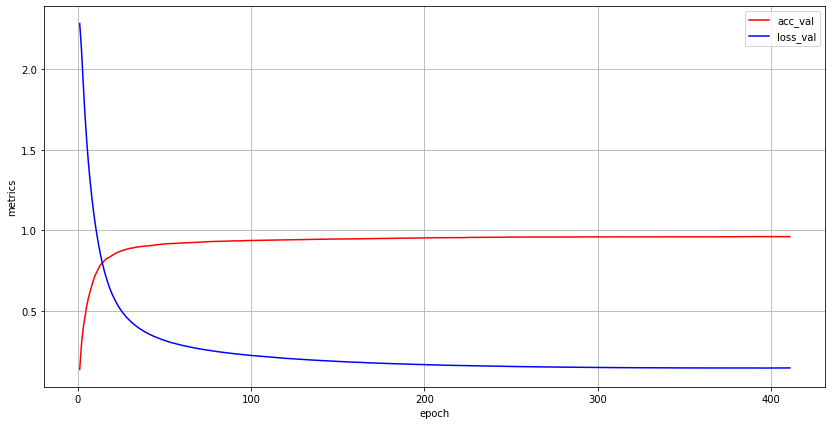

In [7]:
import matplotlib.pyplot as plt

history = dnn_classifier.history
n_epochs = len(history['acc_val'])

epochs = np.arange(1, n_epochs+1)
acc_val = history['acc_val']
loss_val = history['loss_val']

plt.figure(figsize=(14,7))
plt.plot(epochs, acc_val, 'r', label='acc_val')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('metrics')
plt.grid()
plt.show()

In [8]:
from sklearn.metrics import accuracy_score

y_pred = dnn_classifier.predict(X_test)
test_set_score = accuracy_score(y_test, y_pred)

print('test set accuracy = {}'.format(test_set_score))

test set accuracy = 0.9636
